Notebook documenting the learning process for apeture photometry using https://photutils.readthedocs.io/en/stable/psf.html

Terms: Point Spread Function (PSF).

## Source detection

In [1]:
from astropy.stats import sigma_clipped_stats
from photutils import datasets

hdu = datasets.load_star_image()
data = hdu.data[0:401, 0:401]
mean, median, std = sigma_clipped_stats(data, sigma = 3.0)
print((mean, median, std))

(3668.09661145823, 3649.0, 204.41388592022315)


In [3]:
from photutils import DAOStarFinder

daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(data - median)
for col in sources.colnames:
    sources[col].info.format = '%.8g'
print(sources)

 id xcentroid ycentroid sharpness  ... sky peak    flux       mag     
--- --------- --------- ---------- ... --- ---- --------- ------------
  1 144.24757 6.3797904 0.58156257 ...   0 6903 5.6976747   -1.8892441
  2 208.66907 6.8205805 0.48348966 ...   0 7896 6.7186388   -2.0682032
  3 216.92614 6.5775933 0.69359525 ...   0 2195 1.6662764  -0.55436758
  4 351.62519 8.5459013 0.48577834 ...   0 6977 5.8970385   -1.9265849
  5 377.51991 12.065501 0.52038488 ...   0 1260 1.1178252  -0.12093477
  6 294.27284 12.737191 0.68021892 ...   0 2059 1.4809613  -0.42635928
  7 85.217728 14.710347 0.62394134 ...   0 1458 1.2457081  -0.23854075
  8 137.94129 17.464718 0.54340548 ...   0 5451 4.6833069   -1.6763815
  9 130.32797 18.678087 0.62723987 ...   0 3432 2.8641222   -1.1424789
 10  143.1105 18.623553 0.52124876 ...   0 6722 5.7556336   -1.9002329
...       ...       ...        ... ... ...  ...       ...          ...
276 292.58712 389.31304  0.3548582 ...   0 9231   4.64095   -1.6665172
277  9

Plot the image and locations of detected sources:

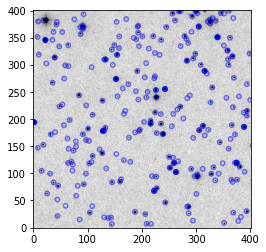

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch = SqrtStretch())

plt.imshow(data, cmap = 'Greys', origin = 'lower', norm = norm, interpolation = 'nearest')
apertures.plot(color = 'blue', lw = 1.5, alpha = 0.5)

## PSF photometry

The following code is an example of IterativelySubtractedPSFPhotometry:

In [9]:
# this shows the basic usage of the procedure:
# create an ISPSFP object
 # from photutils.psf import IterativelySubtractedPSFPhotometry

 # my_phot = IterativelySubtractedPSFPhotometry(finder=my_finder, group_maker=my_group_maker, 
 #                                            bkg_estimator=my_bkg_estimator, psf_model=my_psf_model,
 #                                           fitter=my_fitter, niters=3, fitshape=(7,7))
# obtain photometry results
 # photometry_results = my_phot(image=my_image)
# obtain residual image
 # residual_image = my_phot.get_residual_image()

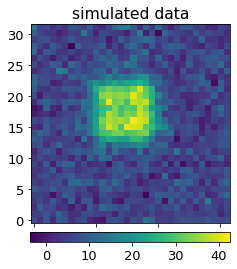

In [14]:
# create an image with four overlapping stars

import numpy as np
from astropy.table import Table
from photutils.datasets import (make_random_gaussians_table,
                                make_noise_image,
                                make_gaussian_sources_image)
sigma_psf = 2.0
sources = Table()
sources['flux'] = [700, 800, 700, 800]
sources['x_mean'] = [12, 17, 12, 17]
sources['y_mean'] = [15, 15, 20, 20]
sources['x_stddev'] = sigma_psf * np.ones(4)
sources['y_stddev'] = sources['x_stddev']
sources['theta'] = [0, 0, 0, 0]
sources['id'] = [1, 2, 3, 4]
tshape = (32, 32)
image = (make_gaussian_sources_image(tshape, sources) + 
         make_noise_image(tshape, distribution = 'poisson', mean = 6) +
         make_noise_image(tshape, distribution = 'gaussian', mean = 0, stddev = 2.))

from matplotlib import rcParams

rcParams['font.size'] = 13

plt.imshow(image, cmap = 'viridis', aspect = 1, interpolation = 'nearest', origin = 'lower')
plt.title('simulated data')
plt.colorbar(orientation = 'horizontal', fraction = 0.046, pad = 0.04)

In [15]:
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

In [25]:
bkgrms = MADStdBackgroundRMS()
std = bkgrms(image)
iraffind = IRAFStarFinder(threshold = 3.5 * std,
                          fwhm = sigma_psf * gaussian_sigma_to_fwhm,
                          minsep_fwhm = 0.01, roundhi = 5.0, roundlo = -5.0,
                          sharplo = 0.0, sharphi = 2.0)
daogroup = DAOGroup(2.0 * sigma_psf * gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma = sigma_psf)

from photutils.psf import IterativelySubtractedPSFPhotometry

photometry = IterativelySubtractedPSFPhotometry(finder = iraffind, group_maker = daogroup,
                                                 bkg_estimator = mmm_bkg,
                                                 psf_model = psf_model,
                                                 fitter = LevMarLSQFitter(),
                                                 niters = 1, fitshape = (11, 11))
result_tab = photometry(image = image)
residual_image = photometry.get_residual_image()

print(result_tab)

       x_0               x_fit        ...       y_0_unc       iter_detected
------------------ ------------------ ... ------------------- -------------
12.636452420473805 12.089260474879248 ...  0.1044937421945992             1
 16.61950930104317   17.0889879028032 ... 0.09451975042362382             1
12.538959499153803 11.857341762017642 ... 0.11150008605523166             1
16.621331827432066 16.976942258657044 ... 0.10127238576735105             1


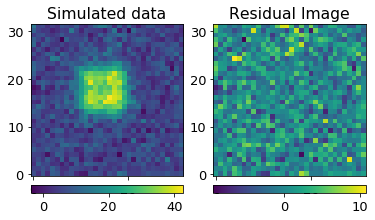

In [20]:
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='viridis', aspect=1, interpolation='nearest',
               origin='lower')
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.subplot(1 ,2, 2)
plt.imshow(residual_image, cmap='viridis', aspect=1,
           interpolation='nearest', origin='lower')
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.show()

## Fixed centroids

Consider the previous example after "psf_model = IntegratedGaussianPRF(sigma = sigma_psf)"

In [23]:
from photutils.psf import BasicPSFPhotometry

psf_model.x_0.fixed = True
psf_model.y_0.fixed = True
pos = Table(names = ['x_0', 'y_0'], data = [sources['x_mean'], sources['y_mean']])

photometry = BasicPSFPhotometry(group_maker = daogroup,
                                bkg_estimator = mmm_bkg,
                                psf_model = psf_model,
                                fitter = LevMarLSQFitter(),
                                fitshape = (11,11))
result_tab = photometry(image = image, init_guesses = pos)
residual_image = photometry.get_residual_image()

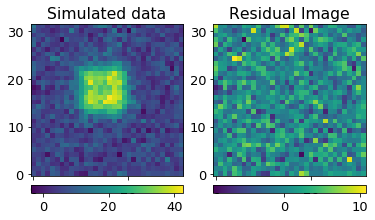

In [24]:
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='viridis', aspect=1,
            interpolation='nearest', origin='lower')
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.subplot(1 ,2, 2)
plt.imshow(residual_image, cmap='viridis', aspect=1,
            interpolation='nearest', origin='lower')
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)